<a href="https://colab.research.google.com/github/AdamVinestock/NLP/blob/main/NLP_Named_Entity_Recognition_(NER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition (NER)
## Training a neural named entity recognition (NER) tagger

In this notebook we will build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset we will be working on are called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/):

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:  

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


All additional packages:

In [1]:
# !pip install --q

Imports:

In [2]:
# general
import os
import copy
import random
import warnings
from typing import List,Tuple
from collections import defaultdict
import requests
import zipfile


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report


set warnings filter to ignore:

In [3]:
# TO DO
import warnings; warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="spectral initialisation failed")

Set random SEEDs:

In [4]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(42)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Set GPU:

In [5]:
# make sure we're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Task 1:
We will write a function for reading the data from a single file (of the ones that are provided above).   
- The function recieves a filepath
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags.
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [6]:
def read_data(filepath: str) -> List[Tuple[List[str], List[str]]]:
    data = []
    response = requests.get(filepath)
    lines = response.text.split("\n")
    sentence = []
    tags = []
    for line in lines:
        line = line.strip()
        if line:
            parts = line.split(" ")
            word = parts[0]
            tag = parts[-1]
            sentence.append(word)
            tags.append(tag)
        else:
            if sentence and tags:
              data.append((sentence, tags))
              sentence = []
              tags = []
    if sentence and tags:
        data.append((sentence, tags))
    return data

# GitHub
train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

train = read_data(train_link)
dev = read_data(dev_link)
test = read_data(test_link)

<br><br><br><br><br><br>



## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.   
The UNK_TOKEN should be used for words that are not part of the training data.

In [7]:
UNK_TOKEN = 1
PAD_TOKEN = 0

class Vocab:
    def __init__(self,train:List[Tuple[List[str],List[str]]]):
        self.word2id = {"Pad_token": PAD_TOKEN, "__unk__": UNK_TOKEN}
        self.id2word = {PAD_TOKEN: "Pad_token" , UNK_TOKEN: "__unk__"}
        self.n_words = 2

        self.n_tags = 1
        self.tag2id = {"Pad_token": PAD_TOKEN}
        self.id2tag = {PAD_TOKEN: "Pad_token"}

        self.init_tag_id(train)
        self.init_word_id(w for w in train)

    def init_tag_id(self, train: List[Tuple[List[str], List[str]]]):
        tag_set = set()
        for _, tags in train:
            tag_set.update(tags)
        self.tag2id = {tag: i+1 for i, tag in enumerate(sorted(tag_set))}
        self.id2tag = {i: tag for tag, i in self.tag2id.items()}
        self.n_tags = len(tag_set)+1

    def init_word_id(self, train: List[Tuple[List[str], List[str]]]):
        word_set = set()
        for word, _ in train:
            word_set.update(word)
        new_words = {word: i+2 for i, word in enumerate(sorted(word_set))}
        self.word2id.update(new_words)
        self.id2word = {i+2: word for word, i in self.word2id.items()}
        self.n_words = len(word_set)+2


    def index_tags(self, tags:List[str]) -> List[int]:
      tag_indexes = [self.tag2id[t] for t in tags]
      return tag_indexes

    def index_words(self, words:List[str]) -> List[int]:
      word_indexes = [self.index_word(w) for w in words]
      return word_indexes

# Testing
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()


In [8]:
vcb.tag2id

{'B-LOC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'I-LOC': 4,
 'I-ORG': 5,
 'I-PER': 6,
 'O': 7}

Now we will write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.  

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [9]:
def prepare_data(data, _vocab=None):
    data_sequences = []

    for tuple in data:
      sentence_ids = [1 if word not in _vocab.word2id.keys() else _vocab.word2id[word] for word in tuple[0]] # map unkown words to id:1
      tag_ids = [_vocab.tag2id[tag] for tag in tuple[1]]
      data_sequences.append((sentence_ids, tag_ids))

    return data_sequences

train_sequences = prepare_data(train, vcb)
dev_sequences = prepare_data(dev, vcb)
test_sequences = prepare_data(test, vcb)

How many OOV words are in the dev dataset?

In [10]:
oov_count = 0
for tuple in dev_sequences:
  oov_count += tuple[0].count(1)
print(f"Number of OOV words in dev dataset is: {oov_count}")

Number of OOV words in dev dataset is: 638


How many OOV words are in the test dataset?

In [11]:
oov_count = 0
for tuple in test_sequences:
  oov_count += tuple[0].count(1)
print(f"Number of OOV words in test dataset is: {oov_count}")

Number of OOV words in test dataset is: 1368


<br><br><br><br><br><br>

## Task 3:

Now we will write NERNet, a PyTorch Module for labeling words with NER tags.

> `input_size`: the size of the vocabulary  
`embedding_size`: the size of the embeddings  
`hidden_size`: the LSTM hidden size  
`output_size`: the number tags we are predicting for  
`n_layers`: the number of layers we want to use in LSTM  
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively  

<br>  

The input for the forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embeddings. That means that you don't need to use pretrained embeddings. We will use them in part 5.*

In [12]:
import torch.nn.utils.rnn as rnn_utils

class NERNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers, directions):
        super(NERNet, self).__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, bidirectional = directions)
        if directions:
          self.out = nn.Linear(hidden_size*2, output_size)
        else:
          self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_sentence):

        lengths = torch.sum(input_sentence != 0, dim=1).to('cpu')                                          # Calculate the lengths from the padded sequence tensor
        x = self.embedding(input_sentence)                                                                 # Embbed the input
        packed_inputs = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=True)  # Pack the inputs
        packed_outputs, _ = self.lstm(packed_inputs)                                                       # Pass the packed inputs through the LSTM layer
        outputs, _ = rnn_utils.pad_packed_sequence(packed_outputs, batch_first=True, total_length=input_sentence.size(1))    # Unpack the packed outputs
        x = self.out(outputs)

        return x


Create a Dataloader for the training phase

In [13]:
from torch.utils.data import DataLoader, TensorDataset

def sort_batch(batch):
    sorted_batch = sorted(batch, key=lambda x: sum(x[0] != 0), reverse=True) # Sort batch based on sequence length (shortest padding)
    sequences, labels = zip(*sorted_batch)                                   # Unpack sorted batch into separate sequences, labels
    return torch.stack(sequences), torch.stack(labels)                       # Return the unpacked batch as tensor types

def prepare_data_loader(sequences, vocab, batch_size=32):
    # Find the length of the longest sequence
    longest_sentence = max(len(seq[0]) for seq in sequences)

    # Pad the sequences
    padded_word_ids = []
    padded_tag_ids = []
    for seq in sequences:
        word_ids, tag_ids = seq
        word_ids.extend([0] * (longest_sentence - len(word_ids)))   # pad with 0's
        tag_ids.extend([0] * (longest_sentence - len(tag_ids)))     # pad with 0's
        padded_word_ids.append(word_ids)
        padded_tag_ids.append(tag_ids)

    # Stack the padded sequences into a single tensor
    padded_word_ids = torch.stack([torch.tensor(seq) for seq in padded_word_ids])
    padded_tag_ids = torch.stack([torch.tensor(seq) for seq in padded_tag_ids])

    # Create a DataLoader
    dataset = TensorDataset(padded_word_ids, padded_tag_ids)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=sort_batch)

    return dataloader

dl_train  = prepare_data_loader(train_sequences, vcb, batch_size = 64)
dl_dev    = prepare_data_loader(dev_sequences, vcb, batch_size = 64)
dl_test   = prepare_data_loader(test_sequences, vcb, batch_size = 64)

## Task 4:

Now we will write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.  

The function will return the `loss` and `accuracy` durring training.  

The loss is always CrossEntropyLoss and the optimizer is always Adam.
We will also make sure to use `tqdm` while iterating on `n_epochs`.

In [14]:
def train_loop(model, n_epochs, dataloader_train, dataloader_dev):

  # Loss function
  criterion = nn.CrossEntropyLoss(ignore_index = 0)

  # Optimizer
  optimizer = Adam(model.parameters(), lr=0.0001)

  # record
  metrics = {'loss':{'train':[], 'dev':[]}, 'accuracy':{'train':[], 'dev':[]} }


  for epoch in tqdm(range(n_epochs), desc='Training'):
      # Training
      model.train()
      train_loss = 0.0
      train_correct = 0
      train_tokens = 0

      for inputs, labels in dataloader_train:
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          optimizer.zero_grad()
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 2)

          outputs = outputs.view(-1, outputs.size(-1))   # Reshape [batch_size, sequence_length, num_tags] -->  [batch_size * sequence_length, num_tags]
          labels = labels.view(-1)                       # Reshape  [batch_size, sequence_length] --> [batch_size * sequence_length]
          predicted = predicted.view(-1)                 # Reshape [batch_size, sequence_length] -->  [batch_size * sequence_length]

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          labels_id_no_pad = (labels != PAD_TOKEN)
          labels_wo_padding = labels[labels_id_no_pad]         # remove the padding from the labels
          predicted_wo_padding = predicted[labels_id_no_pad]   # remove the padding tokens from the predictions

          train_correct += (predicted_wo_padding == labels_wo_padding).sum().item()
          train_tokens += len(labels_wo_padding)

      train_loss /= train_tokens
      train_accuracy = train_correct / train_tokens

      metrics['loss']['train'].append(train_loss)
      metrics['accuracy']['train'].append(train_accuracy)

      # Evaluation on dev set
      model.eval()
      dev_loss = 0.0
      dev_correct = 0
      dev_total = 0
      dev_tokens = 0

      with torch.no_grad():
          for inputs, labels in dataloader_dev:
              inputs = inputs.to(DEVICE)
              labels = labels.to(DEVICE)
              outputs = model(inputs)
              _, predicted = torch.max(outputs, 2)

              outputs = outputs.view(-1, outputs.size(-1))   # Reshape [batch_size, sequence_length, num_tags] -->  [batch_size * sequence_length, num_tags]
              labels = labels.view(-1)                       # Reshape  [batch_size, sequence_length] --> [batch_size * sequence_length]
              predicted = predicted.view(-1)                 # Reshape [batch_size, sequence_length] -->  [batch_size * sequence_length]

              loss = criterion(outputs, labels)

              labels_id_no_pad = (labels != PAD_TOKEN)
              labels_wo_padding = labels[labels_id_no_pad]         # remove the padding from the labels
              predicted_wo_padding = predicted[labels_id_no_pad]   # remove the padding tokens from the predictions

              dev_loss += loss.item()
              dev_correct += (predicted_wo_padding == labels_wo_padding).sum().item()
              dev_tokens += len(labels_wo_padding)

      dev_loss /= dev_tokens
      dev_accuracy = dev_correct / dev_tokens

      metrics['loss']['dev'].append(dev_loss)
      metrics['accuracy']['dev'].append(dev_accuracy)

  return metrics

## Task 5:
Now we will write an evaluation loop on a trained model, using the dev and test datasets.   
This function will print a `classification_report` and plot a `confusion matrix`.  
This will be done for each label seperately (7 labels in total), and a calculation for all the 6 labels (except O) together.   





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic mean
- *For all these metries we will use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

We will display:
1. A `classification_report` in a `tabulate` format.
2. A `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

def remove_label(y_pred, y_true, label):
    y_true_no_lbl = np.where(y_true != label)[0]    # All indices without the label
    y_true = y_true[y_true_no_lbl]                  # Remove all true labels with tag 'O'
    y_pred = y_pred[y_true_no_lbl]                  # Remove all corresponding pred labels

    y_pred_no_lbl = np.where(y_pred != label)[0]
    y_true = y_true[y_pred_no_lbl]                  # Remove all pred labels with tag 'O'
    y_pred = y_pred[y_pred_no_lbl]                  # Remove all corresponding pred labels

    return y_pred, y_true

def evaluate_metrics(model, title, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    results = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 2)

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # Calculate metrics over predictions and insert into results
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred, y_true = remove_label(y_pred, y_true, 0)
    precision, recall, f_1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
    results.extend([recall, precision, f_1])

    # Calculate metrics over predictions and insert into results (for no outside tags)
    y_pred_no_O, y_true_no_O = remove_label(y_pred, y_true, 7)
    precision, recall, f_1, _ = precision_recall_fscore_support(y_true_no_O, y_pred_no_O, average='weighted', zero_division=1)
    results.extend([recall, precision, f_1])

    return results, y_true, y_pred

def eval_CM(title, y_true, y_pred):

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vcb.tag2id.keys())
    disp.plot()
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # Confusion Matrix without label 'O'
    y_pred, y_true = remove_label(y_pred, y_true, 7)
    cm = confusion_matrix(y_true, y_pred)
    display_labels_without_o = [label for label in vcb.tag2id.keys() if label != 'O']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels_without_o)
    disp.plot()
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

In [16]:
# Creating NERnet NN:
clf = NERNet(vcb.n_words, 300, 512, vcb.n_tags, 1, False).to(DEVICE)

# Training the NN:
train_loop(clf, 10, dl_train, dl_dev)
print("\nFinished training")

Training: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Finished training


+------+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
|      | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS | DIRECTIONS   |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|------+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
| dev  | Model0    |           512 |          1 | False        | 0.807058 |    0.76991  | 0.74402  |      0.744828 |         0.767153 |  0.722858 |
| test | Model0    |           512 |          1 | False        | 0.812432 |    0.767608 | 0.749489 |      0.666667 |         0.703094 |  0.638493 |
+------+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+


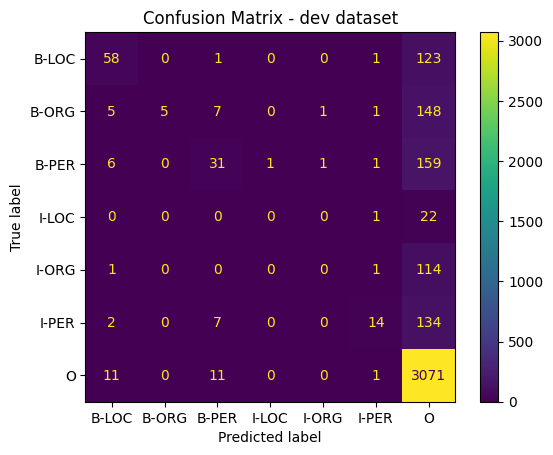

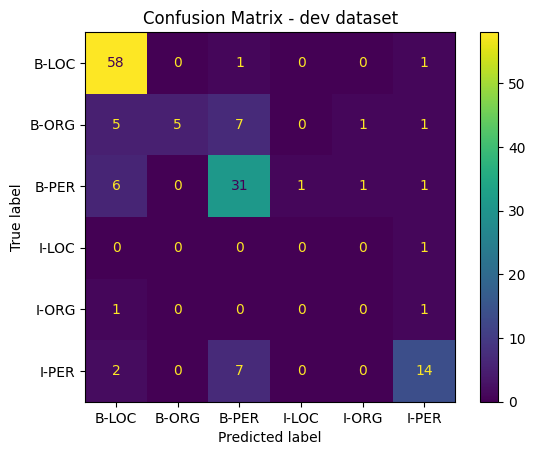

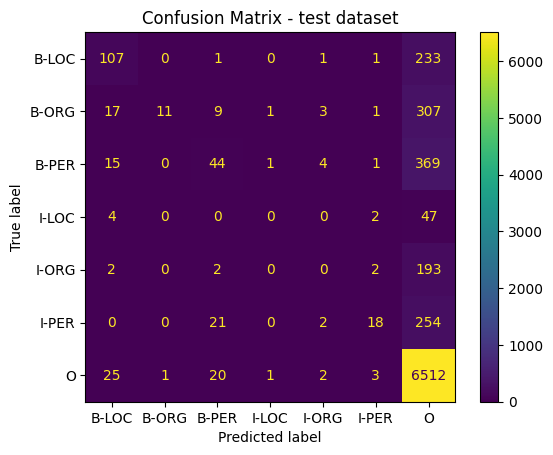

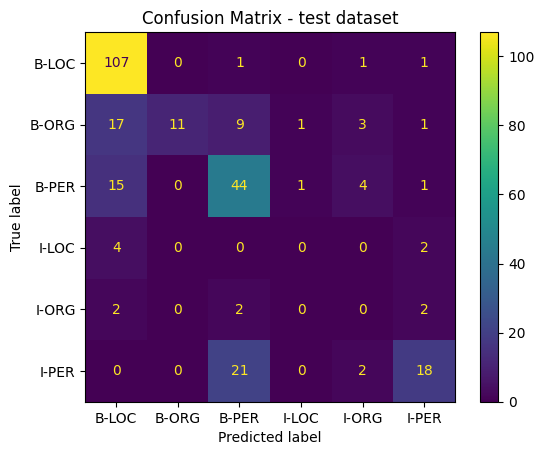

In [17]:
metrics_dev, y_true_dev, y_pred_dev = evaluate_metrics(clf, "dev dataset", dl_dev)
metrics_test, y_true_test, y_pred_test = evaluate_metrics(clf, "test dataset", dl_test)
results = [['Model0','512', '1', 'False'] + metrics_dev,
           ['Model0','512', '1', 'False'] + metrics_test]
df = pd.DataFrame(results, columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL', 'PERCISION','F1','RECALL_WO_O', 'PERCISION_WO_O','F1_WO_O'],
                  index=['dev', 'test'])
file_name = '{312332372}_{209795624}_part5.csv'
df.to_csv(file_name)

print(tabulate(df, headers='keys', tablefmt='psql'))

eval_CM("dev dataset", y_true_dev, y_pred_dev)
eval_CM("test dataset", y_true_test, y_pred_test)

## Task 6:

Reset all seeds to 42.

In [18]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(42)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Now we will train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters:

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




Training: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


 
Confusion matrix for Model_1:


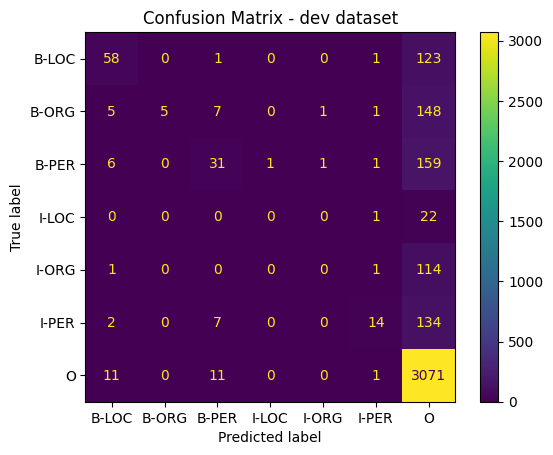

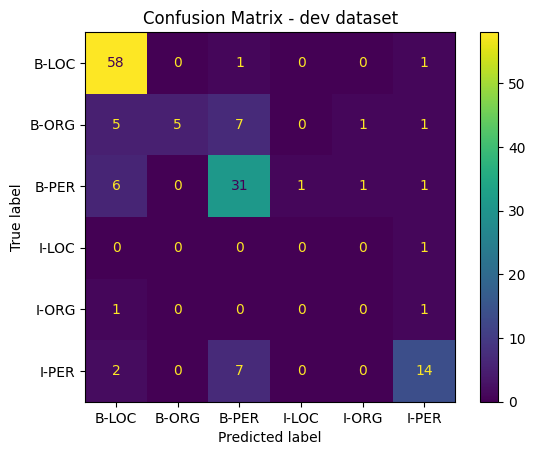

Training: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


 
Confusion matrix for Model_2:


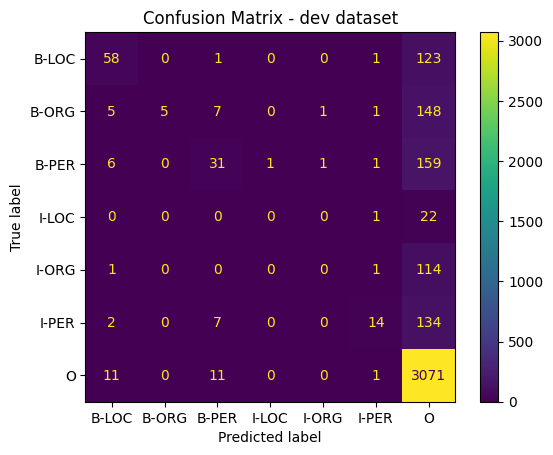

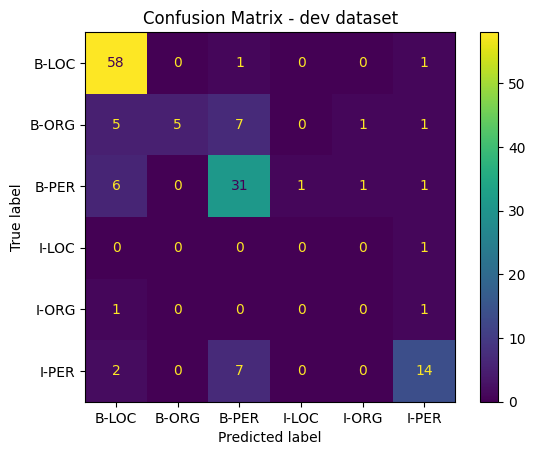

Training: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


 
Confusion matrix for Model_3:


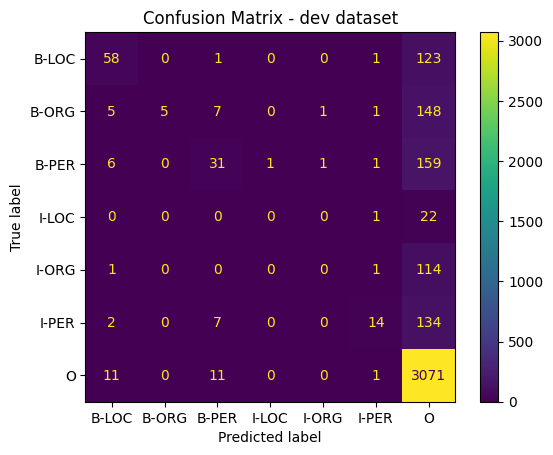

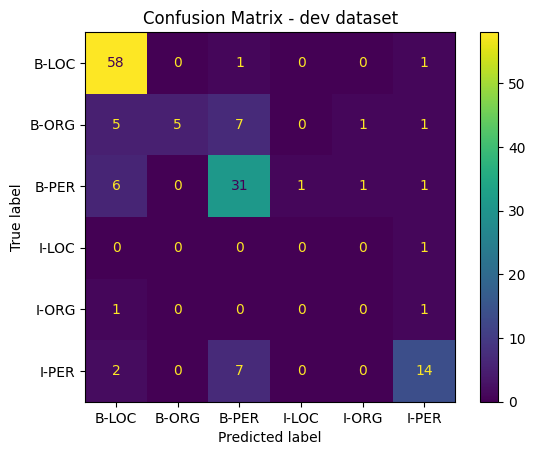

Training: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


 
Confusion matrix for Model_4:


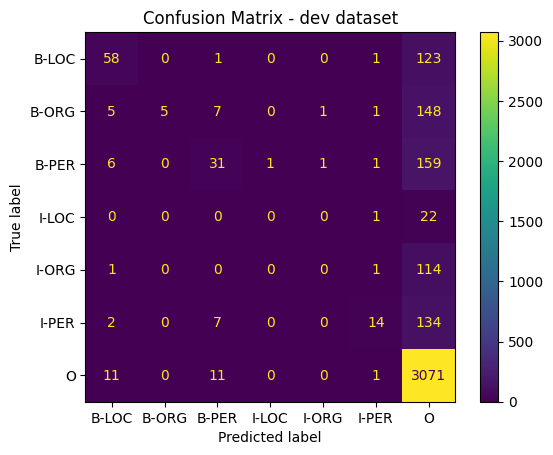

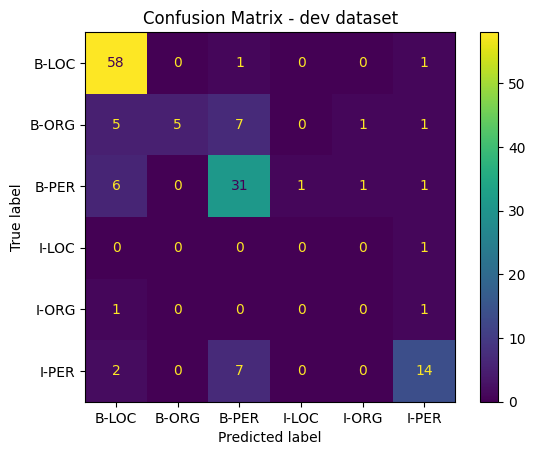

Training: 100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


 
Confusion matrix for Model_5:


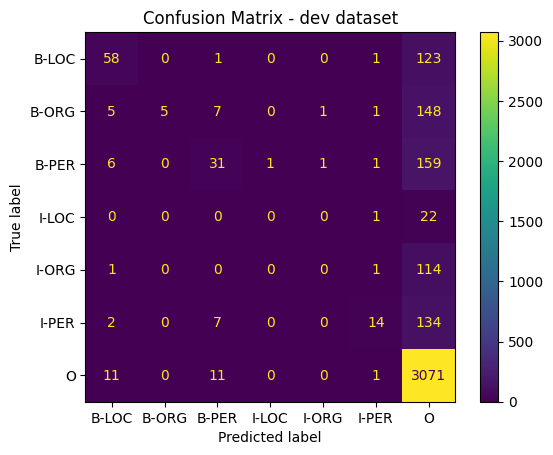

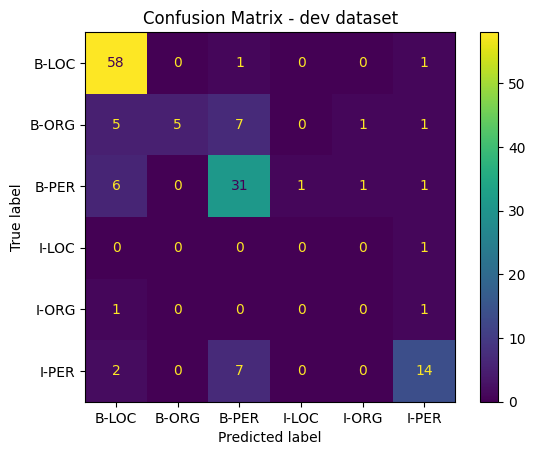

Training: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


 
Confusion matrix for Model_6:


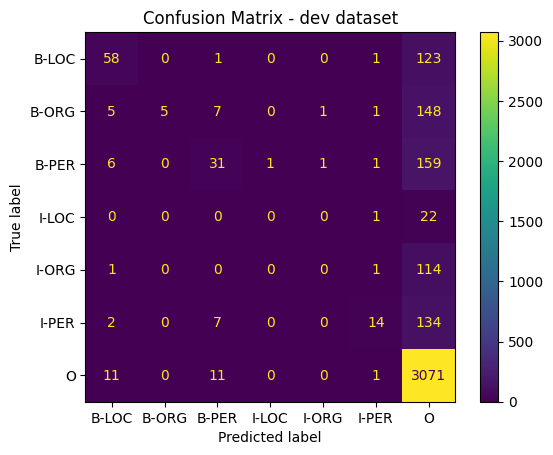

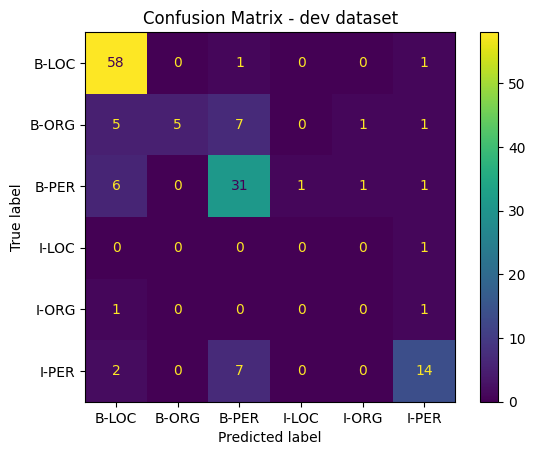

Training: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


 
Confusion matrix for Model_7:


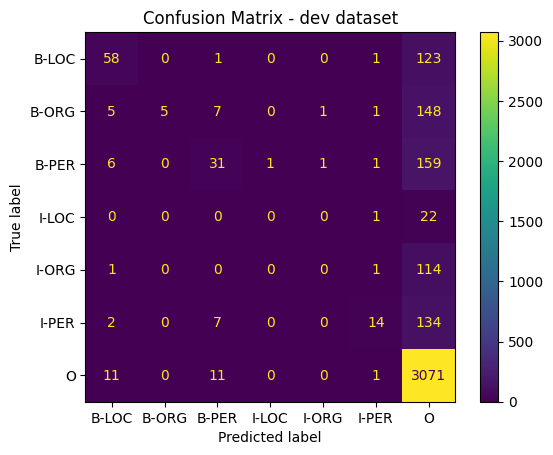

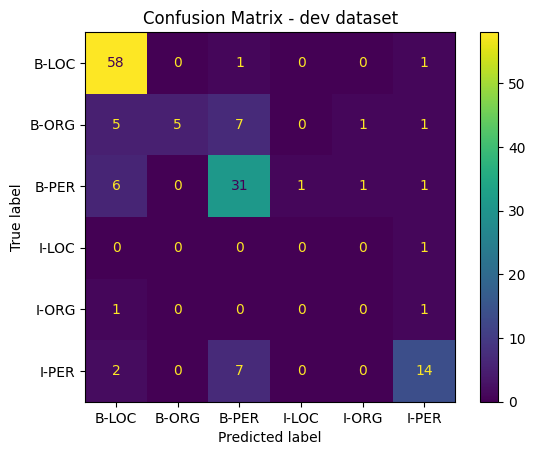

Training: 100%|██████████| 20/20 [01:00<00:00,  3.03s/it]


 
Confusion matrix for Model_8:


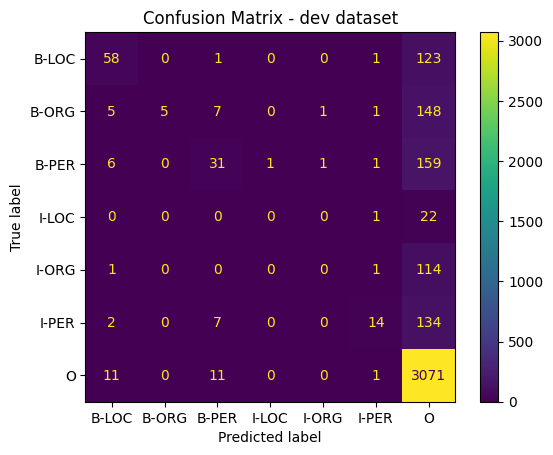

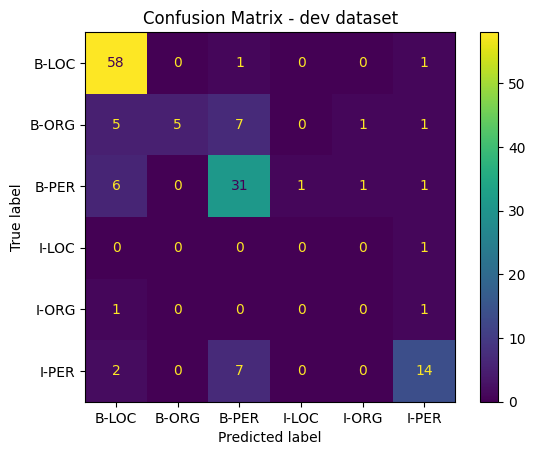

Training: 100%|██████████| 20/20 [01:28<00:00,  4.40s/it]


 
Confusion matrix for Model_9:


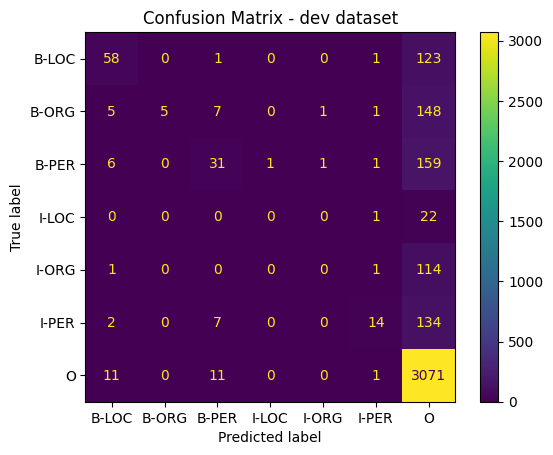

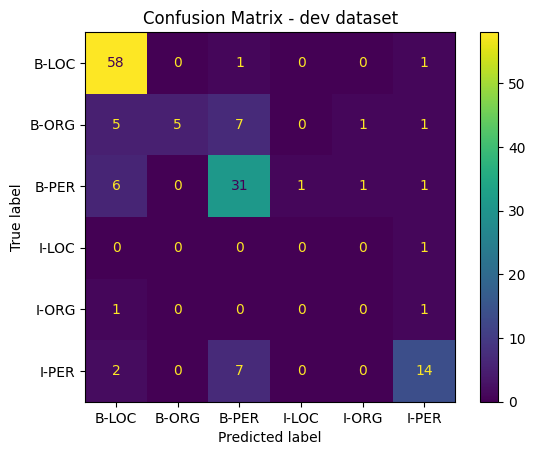

 Final Mertices Table - Dev Dataset:
+----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
|  0 | Model_1   |           500 |          1 |            1 | 0.842506 |    0.8204   | 0.809336 |      0.798319 |         0.795269 |  0.778378 |
|  1 | Model_2   |           500 |          2 |            1 | 0.851777 |    0.835284 | 0.826026 |      0.835979 |         0.83442  |  0.832754 |
|  2 | Model_3   |           500 |          3 |            1 | 0.839462 |    0.812361 | 0.819055 |      0.754923 |         0.757916 |  0.741813 |
|  3 | Model_4   |           500 |          1 |            2 | 0.867073 |    0.856928 |

In [19]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL', 'PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
models = {
    'Model_1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model_2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model_3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model_4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model_5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model_6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model_7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model_8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model_9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

results = []
trained_models = {}
for model, model_v in models.items():
  directions = False if model_v['directions']==1 else True
  clf = NERNet(vcb.n_words, model_v['embedding_size'], model_v['hidden_size'], vcb.n_tags, model_v['n_layers'], directions)
  clf = clf.to(DEVICE)
  train_loop(clf, 20, dl_train, dl_dev)
  metrics, y_true, y_pred = evaluate_metrics(clf, "dev dataset", dl_dev)
  results.append([model, model_v['hidden_size'], model_v['n_layers'], model_v['directions']] + metrics)
  model_v[model] = copy.copy(clf)
  print(" ")
  print(f"\033[1mConfusion matrix for {model}:\033[1m")
  eval_CM("dev dataset", y_true_dev, y_pred_dev)


df_dev = pd.DataFrame(results, columns=columns ,index= range(9))
print(' Final Mertices Table - Dev Dataset:')
print(tabulate(df_dev, headers='keys', tablefmt='psql'))

**Save CSV**  
In addition, for each model we use the `test` dataset and check the model metrics.

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries we use **weighted** ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

In [20]:
results = []

for model, model_v in models.items():
  metrics, y_true, y_pred = evaluate_metrics(model_v[model], "test dataset", dl_test)
  results.append([model, model_v['hidden_size'], model_v['n_layers'], model_v['directions']] + metrics)

df_test = pd.DataFrame(results, columns=columns, index= range(9))
file_name = '{312332372}_{209795624}_part6.csv'
df_test.to_csv(file_name)
print(' Final Mertices Table - Test Dataset:')
print(tabulate(df_test, headers='keys', tablefmt='psql'))

 Final Mertices Table - Test Dataset:
+----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
|  0 | Model_1   |           500 |          1 |            1 | 0.840956 |    0.812607 | 0.809973 |      0.767883 |         0.763862 |  0.755489 |
|  1 | Model_2   |           500 |          2 |            1 | 0.848926 |    0.821778 | 0.820368 |      0.796537 |         0.804086 |  0.795613 |
|  2 | Model_3   |           500 |          3 |            1 | 0.83671  |    0.813114 | 0.817126 |      0.720504 |         0.733317 |  0.71163  |
|  3 | Model_4   |           500 |          1 |            2 | 0.869296 |    0.859846 

## Task 7:

Reset all seeds to 42.

In [21]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(42)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


As background for section you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: It is important make sure that vectors are aligned with the ID's in the Vocab, for example the word with ID 0 is the first vector in the GloVe matrix of vectors that is initialized with nn.Embedding .*

---


Downloading the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip).


In [22]:
# Download the glove.6B.zip:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-07-20 13:18:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-20 13:18:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.12MB/s    in 2m 39s  

2023-07-20 13:21:23 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [23]:
# Unzipping and extracting the 300-dim vectors:
zip_path = '/content/glove.6B.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_contents')

In [24]:
# Converting glove txt file -> df -> tensor
glove_df = pd.read_csv('/content/extracted_contents/glove.6B.300d.txt', sep=' ', header=None, index_col=0, quoting=3)
glove_df.columns = ['emb_{}'.format(i) for i in range(1, 301)]

glove_embedding = torch.empty(len(vcb.word2id),300)
for word in vcb.word2id:
  if word in glove_df.index:
    row = glove_df.loc[word].values
    embedded_word = torch.tensor(row, dtype=torch.float32)
    glove_embedding[vcb.word2id[word]] = embedded_word
  else:
    # In that case, there is a word in "word2id" that doesn't have any represtative in Glove 6B, there are several ways to represent it:
      # random embedding vector / zeros vector / embedding of 'unk' from Glove 6B
      # We tried them all and didn't find any major differances (using zeros vector was the best method)

    # Random vector:
    #embedded_word = torch.rand(300) * 2 - 1

    # Zeros vector:
    embedded_word = torch.zeros(300)

    # Glove 'unk' embedding values:
    #row = glove_df.loc['unk'].values
    #embedded_word = torch.tensor(row, dtype=torch.float32)
    glove_embedding[vcb.word2id[word]] = embedded_word
glove_embedding = glove_embedding.to(DEVICE)

Then we intialize the `nn.Embedding` module in the `NERNet` with these embeddings, so that we can start training with pre-trained vectors.

In [25]:
gloveNER = NERNet(vcb.n_words, 300, 500, vcb.n_tags, 3, True).to(DEVICE) # Using the best parameters from part 6

# Intializie the nn.Embedding module with GloVe embeddings
gloveNER.embedding = nn.Embedding(glove_embedding.size(0), glove_embedding.size(1))
gloveNER.embedding.weight = nn.Parameter(glove_embedding)

train_loop(gloveNER, 10, dl_train, dl_dev)
print("\nFinished training")

Training: 100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


Finished training


Again we will display:

1. A `classification_report` in a tabulate format.
2. A `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Training: 100%|██████████| 20/20 [01:30<00:00,  4.52s/it]


+----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
|  0 | Model_1   |           500 |          1 |            1 | 0.874803 |    0.858851 | 0.856112 |      0.698556 |         0.705398 |  0.669264 |
|  1 | Model_2   |           500 |          2 |            1 | 0.834526 |    0.881354 | 0.851691 |      0.620763 |         0.686533 |  0.631155 |
|  2 | Model_3   |           500 |          3 |            1 | 0.851739 |    0.893916 | 0.866516 |      0.679562 |         0.764268 |  0.694709 |
|  3 | Model_4   |           500 |          1 |            2 | 0.899187 |    0.916091 | 0.905224 |      0.764744 |         0

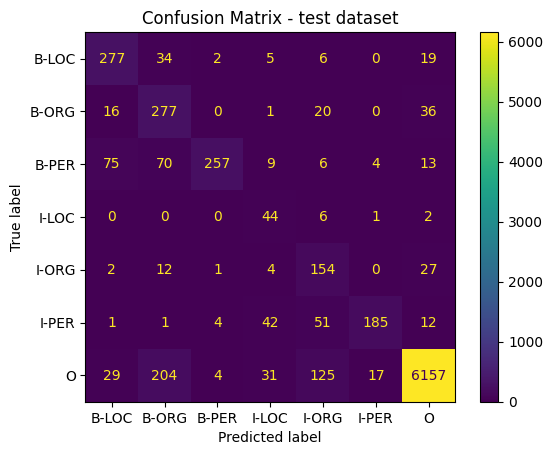

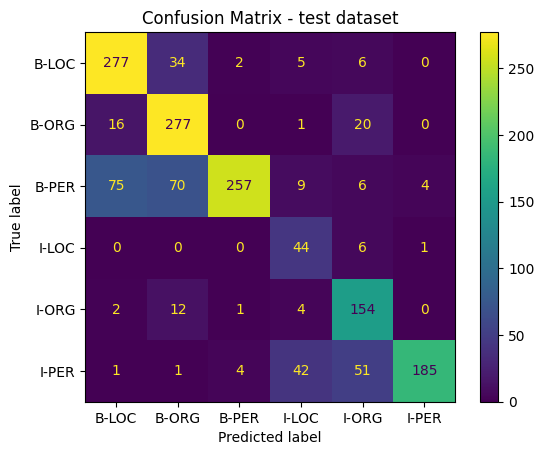

In [26]:
results = []
for model, model_v in models.items():
  directions = False if model_v['directions']==1 else True
  clfGlove = NERNet(vcb.n_words, model_v['embedding_size'], model_v['hidden_size'], vcb.n_tags, model_v['n_layers'], directions).to(DEVICE)
  clfGlove.embedding = nn.Embedding(glove_embedding.size(0), glove_embedding.size(1))
  clfGlove.embedding.weight = nn.Parameter(glove_embedding)
  train_loop(clfGlove, 20, dl_train, dl_dev)
  metrics, y_true, y_pred = evaluate_metrics(clfGlove, "test dataset", dl_test)
  results.append([model, model_v['hidden_size'], model_v['n_layers'], model_v['directions']] + metrics)
  # print(" ")
  # print(f"\033[1mConfusion matrix for Glove {model}:\033[1m")
  # eval_CM("test dataset", y_true, y_pred)

df_glove = pd.DataFrame(results, columns=columns, index= range(9))
file_name = 'part7.csv'
df_glove.to_csv(file_name)

print(tabulate(df_glove, headers='keys', tablefmt='psql'))

print(f"\033[1mConfusion matrix for Glove {model}:\033[1m")
eval_CM("test dataset", y_true, y_pred)